In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

## Unified Robotics Description Forma

URDF is an XML specification to model robots. We will have a closer look at the urdf file for minipupper

### Reference

The following sources helped me to refine my understanding

<a href="https://petercorke.com/download/20/articles/1059/urdf-2.pdf" target="_blank">Understanding URDF using MATLABR - Peter Corke</a>

In [2]:
from xml.dom import minidom

In [3]:
with open('./simple.urdf', 'r') as f:
    xmldoc = minidom.parse(f)

In [4]:
print(xmldoc.toprettyxml())

<?xml version="1.0" ?>
<!-- copied from Understanding URDF using MATLABR - Peter Corke -->
<robot name="planar2">
	
  
	<link name="base_link"/>
	
  
	<link name="link1"/>
	
  
	<link name="link2"/>
	
  
	<link name="end"/>
	
  
	<joint name="q1" type="continuous">
		
    
		<parent link="base_link"/>
		
    
		<child link="link1"/>
		
    
		<axis xyz="0 0 1"/>
		

	</joint>
	
  
	<joint name="q2" type="continuous">
		
    
		<parent link="link1"/>
		
    
		<child link="link2"/>
		
    
		<origin xyz="1 0 0"/>
		
    
		<axis xyz="0 0 1"/>
		
  
	</joint>
	
  
	<joint name="notajoint" type="fixed">
		
    
		<parent link="link2"/>
		
    
		<child link="end"/>
		
    
		<origin xyz="1 0 0"/>
		
  
	</joint>
	

</robot>



In [5]:
def parseDom(node):
    if node.nodeType != minidom.Node.ELEMENT_NODE:
        return
    if node.nodeName == 'transmission':
        # ignore transmission and avoid overwritten links
        return
    if len(node.getAttribute("name")) > 0:
        urdf[node.getAttribute("name")] = node
        if node.nodeName == 'link':
            links.append(node.getAttribute("name"))
        if node.nodeName == 'joint':
            joints.append(node.getAttribute("name"))
    for child in node.childNodes:
        parseDom(child)

In [6]:
urdf = {}
links = []
joints = []
parseDom(xmldoc.documentElement)

In [7]:
for i in range(len(links)):
    print(links[i])               

base_link
link1
link2
end


In [8]:
def geJointParent(node):
    for n in urdf[node].childNodes:
        if n.nodeType != minidom.Node.ELEMENT_NODE:
            continue
        if n.nodeName == 'parent':
            return n.getAttribute('link')

In [9]:
def geJointChild(node):
    for n in urdf[node].childNodes:
        if n.nodeType != minidom.Node.ELEMENT_NODE:
            continue
        if n.nodeName == 'child':
            return n.getAttribute('link')

In [10]:
for i in range(len(joints)):
    print("%s: parent %s child %s" % (joints[i], geJointParent(joints[i]), geJointChild(joints[i])))

q1: parent base_link child link1
q2: parent link1 child link2
notajoint: parent link2 child end


In [11]:
with open('../minipupper_description/urdf/minipupper.urdf', 'r') as f:
    xmldoc = minidom.parse(f)

In [12]:
urdf = {}
links = []
joints = []
parseDom(xmldoc.documentElement)

In [13]:
def getJointOrigin(node):
    for n in urdf[node].childNodes:
        if n.nodeType != minidom.Node.ELEMENT_NODE:
            continue
        if n.nodeName == 'origin':
            return n.getAttribute('xyz')

In [14]:
joints_origin = {}
for i in range(len(joints)):
    if 'debug' in joints[i]:
        continue
    if 'inertia' in joints[i]:
        continue
    origin = getJointOrigin(joints[i])
    joints_origin[joints[i]] = [float(x) for x in origin.split(' ')]
    print("%s: parent %s child %s origin %s" % (joints[i], geJointParent(joints[i]), geJointChild(joints[i]), origin))

lf_hip_joint: parent base_link child lf_hip_link origin 0.06014 0.0235 0.0171
lf_upper_leg_joint: parent lf_hip_link child lf_upper_leg_link origin 0 0.0197 0
lf_lower_leg_joint: parent lf_upper_leg_link child lf_lower_leg_link origin 0 0.00475 -0.05
lf_foot_joint: parent lf_lower_leg_link child lf_foot_link origin 0 0 -0.056
lh_hip_joint: parent base_link child lh_hip_link origin -0.05886 0.0235 0.0171
lh_upper_leg_joint: parent lh_hip_link child lh_upper_leg_link origin 0 0.0197 0
lh_lower_leg_joint: parent lh_upper_leg_link child lh_lower_leg_link origin 0 0.00475 -0.05
lh_foot_joint: parent lh_lower_leg_link child lh_foot_link origin 0 0 -0.056
rf_hip_joint: parent base_link child rf_hip_link origin 0.06014 -0.0235 0.0171
rf_upper_leg_joint: parent rf_hip_link child rf_upper_leg_link origin 0 -0.0197 0
rf_lower_leg_joint: parent rf_upper_leg_link child rf_lower_leg_link origin 0 -0.00475 -0.05
rf_foot_joint: parent rf_lower_leg_link child rf_foot_link origin 0 0 -0.056
rh_hip_joint

In [15]:
locations = ['lf', 'lh', 'rf', 'rh']# robot origin
xs = [0.0]
ys = [0.0]
zs = [0.0]
# hip
for l in locations:
    loc = "%s_hip_joint" % l
    xs.append(joints_origin[loc][0])
    ys.append(joints_origin[loc][1])
    zs.append(joints_origin[loc][2])
# upper leg
for l in locations:
    loc = "%s_upper_leg_joint" % l
    loc_parent = "%s_hip_joint" % l
    xs.append(joints_origin[loc][0] + joints_origin[loc_parent][0])
    ys.append(joints_origin[loc][1] + joints_origin[loc_parent][1])
    zs.append(joints_origin[loc][2] + joints_origin[loc_parent][2])
# lower leg
for l in locations:
    loc = "%s_lower_leg_joint" % l
    loc_parent = "%s_upper_leg_joint" % l
    loc_parent1 = "%s_hip_joint" % l
    xs.append(joints_origin[loc][0] + joints_origin[loc_parent][0] + joints_origin[loc_parent1][0])
    ys.append(joints_origin[loc][1] + joints_origin[loc_parent][1] + joints_origin[loc_parent1][1])
    zs.append(joints_origin[loc][2] + joints_origin[loc_parent][2] + joints_origin[loc_parent1][2])
# foot
for l in locations:
    loc = "%s_foot_joint" % l
    loc_parent = "%s_lower_leg_joint" % l
    loc_parent1 = "%s_upper_leg_joint" % l
    loc_parent2 = "%s_hip_joint" % l
    xs.append(joints_origin[loc][0] + joints_origin[loc_parent][0] + joints_origin[loc_parent1][0] + joints_origin[loc_parent2][0])
    ys.append(joints_origin[loc][1] + joints_origin[loc_parent][1] + joints_origin[loc_parent1][1] + joints_origin[loc_parent2][1])
    zs.append(joints_origin[loc][2] + joints_origin[loc_parent][2] + joints_origin[loc_parent1][2] + joints_origin[loc_parent2][2])

Text(0.5, 0, 'Z')

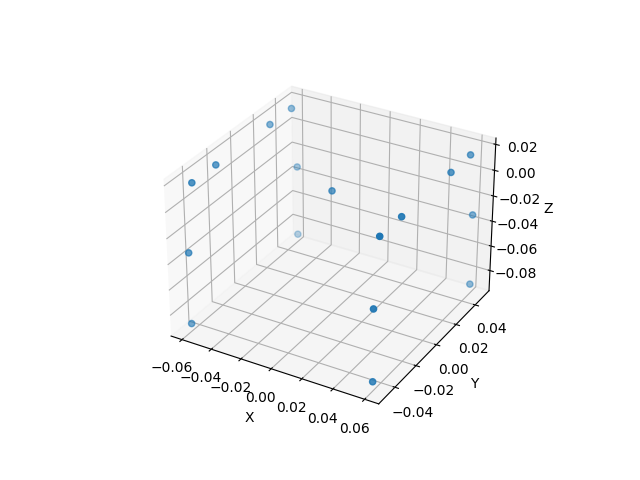

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xs, ys, zs)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## Lenght of legs

Calculate the lenght of the upper and lower leg based on information from the URDF file

We will use this information for our inverse kinematics

In [17]:
print("Lenght of upper leg: %s" % np.linalg.norm(np.array(joints_origin['lh_lower_leg_joint'])))
print("Lenght of lower leg: %s" % np.linalg.norm(np.array(joints_origin['lh_foot_joint'])))

Lenght of upper leg: 0.05022511821787979
Lenght of lower leg: 0.056


## Urdfpy

There is more work to do to properly parse a URDF file. We will use a library

<a href="https://urdfpy.readthedocs.io/en/latest/index.html" target="_blank">Urdfpy Documentation</a>


urdfpy currently requires networkx==2.2 but this version is broken on Python 3.9

pip uninstall networkx

pip install networkx

and ignore the warnings

If you want to display ur5

pip uninstall pyrender

pip install git+https://github.com/mmatl/pyrender.git

In [18]:
from urdfpy import URDF

# uncomment the urdf file you want to work on. Leave None if you want to skip this step
robot=None
# we use a modified version because the original file throws an error
#robot = URDF.load('../minipupper_description/urdf/minipupper_edited.urdf')
#robot = URDF.load('./simple_visual.urdf')
#robot = URDF.load('../ur5/ur5.urdf')

In [19]:
if robot is not None:
    for link in robot.links:
        print(link.name)

In [20]:
if robot is not None:
    for joint in robot.joints:
        print('{} connects {} to {}'.format(
               joint.name, joint.parent, joint.child
              ))

In [21]:
if robot is not None:
    for joint in robot.actuated_joints:
        print(joint.name)

In [22]:
if robot is not None:
    if robot.name == 'minipupper':
        cfg={
             'lf_hip_joint': 0.0,
             'lh_hip_joint': 0.0,
             'rf_hip_joint': 0.0,
             'rh_hip_joint': 0.0,
             'lf_upper_leg_joint': math.pi/4,
             'lh_upper_leg_joint': math.pi/4,
             'rf_upper_leg_joint': math.pi/4,
             'rh_upper_leg_joint': math.pi/4,
             'lf_lower_leg_joint': -math.pi/2,
             'lh_lower_leg_joint': -math.pi/2,
             'rf_lower_leg_joint': -math.pi/2,
             'rh_lower_leg_joint': -math.pi/2
            }
    if robot.name == 'planar2':
        cfg={'q1': 0.0, 'q2': math.pi/4}   
    if robot.name == 'ur5':
        cfg={
              'shoulder_pan_joint': 0.0,
              'shoulder_lift_joint': 2.0,
              'elbow_joint': 2.0,
              'wrist_1_joint': 0.0,
              'wrist_2_joint': 0.0,
              'wrist_3_joint': 0.0,
            }
            

In [23]:
import math
# Attention, the following will open a new Window but does not terminate properly (Mac OS)
if robot is not None:
    robot.show(cfg=cfg)